In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

/Users/wknq25/opt/anaconda3/envs/geocoder_py38/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/fg/_n1n9v7x7x1bk7m6gwfkv97m0000gp/T/ipykernel_16758/825343298.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to S

In [2]:
output_suffix = "alignment_test3"

In [8]:
list_of_census = [
    "EW_1851",
    "EW_1861",
    "EW_1881",
    "EW_1891",
    "EW_1901",
    "EW_1911",
    "SCOT_1851",
    "SCOT_1861",
    "SCOT_1871",
    "SCOT_1881",
    "SCOT_1891",
    "SCOT_1901"
]

# list_of_census = [

#     "SCOT_1851"

# ]


In [9]:
for census in list_of_census:

    country = census.split("_")[0]
    year = census.split("_")[1]
    print(country, year)
    print("reading census")
    geom_linked = pd.read_csv(f"analysis_{output_suffix}/{year}/{country}/link_lkup_merged_geoms.tsv", sep = "\t")
    print("reading boundary data")
    geom_data = gpd.read_file(f"output_{output_suffix}/{year}/{country}/{year}_{country}_boundary.geojson")

    print("generating administrative unit id for census")
    if country == "EW":
        if int(year) > 1891:
            conparid = "conparid_01-11"
        else:
            conparid = "conparid_51-91"
        geom_linked[conparid] = pd.to_numeric(geom_linked["unique_add_id"].str.split("_").str[1], errors = "raise", downcast="integer")
        geom_linked[f"CEN_{year}"] = pd.to_numeric(geom_linked["unique_add_id"].str.split("_").str[2], errors = "raise", downcast="integer")
        geom_linked["adm_unit_id"] = geom_linked[conparid].astype(str) + "_" + geom_linked[f"CEN_{year}"].astype(str)

        print("generating administrative unit for boundaries")
        geom_data[conparid] = pd.to_numeric(geom_data[conparid], errors = "raise", downcast="integer")
        geom_data["adm_unit_id"] = geom_data[conparid].astype(str) + "_" + geom_data[f"CEN_{year}"].astype(str)

    else:
        geom_linked["adm_unit_id"] = pd.to_numeric(geom_linked["unique_add_id"].str.split("_").str[1], errors = "raise", downcast="integer")
        geom_data["adm_unit_id"] = geom_data["merged_id"]

    total_by_unit_and_geocode = geom_linked.groupby(["adm_unit_id", "geocode"]).size()
    total_by_unit_and_geocode_lnk = total_by_unit_and_geocode.unstack(level=1).reset_index()
    cols_to_sum = geom_linked["geocode"].unique()
    total_by_unit_and_geocode_lnk["total_pop"] = total_by_unit_and_geocode_lnk[cols_to_sum].sum(axis=1)
    perc_by_unit_and_geocode = (total_by_unit_and_geocode / total_by_unit_and_geocode.groupby("adm_unit_id").transform("sum") * 100)
    perc_by_unit_and_geocode = perc_by_unit_and_geocode.unstack(level=1).reset_index()
    perc_by_unit_and_geocode["linked_total"] = 100 - perc_by_unit_and_geocode["not_linked"]

    #temp
    # geom_data.to_csv("missing_check_geom_data.tsv", sep = "\t")
    # geom_linked.to_csv("missing_check_geom_linked.tsv", sep = "\t")
    # perc_by_unit_and_geocode.to_csv("missing_check_perc_by_unit_and_geocode.tsv", sep = "\t")
    # total_by_unit_and_geocode_lnk.to_csv("missing_check_total_by_unit_geocode_lnk.tsv", sep = "\t")

    mapping_output = pd.merge(left = geom_data, right = total_by_unit_and_geocode_lnk, on = "adm_unit_id", how = "left", validate="one_to_one")

    #temp
    # mapping_output.to_csv("missing_check_mapping_output.tsv", sep = "\t")



    mapping_output = pd.merge(left = mapping_output, right = perc_by_unit_and_geocode, on = "adm_unit_id", how = "left", validate="one_to_one", suffixes=["_n", "_perc"]).fillna(0)



    output_params = { 
        "crs": "EPSG:27700",
        "driver": "GeoJSON"}

    mapping_output.to_file(f"analysis_{output_suffix}/{year}/{country}/{year}_{country}_mapping_by_adm_unit_corrected.geojson", **output_params)


EW 1851
reading census


/var/folders/fg/_n1n9v7x7x1bk7m6gwfkv97m0000gp/T/ipykernel_8232/1857136889.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  geom_linked = pd.read_csv(f"analysis_{output_suffix}/{year}/{country}/link_lkup_merged_geoms.tsv", sep = "\t")


reading boundary data
generating administrative unit id for census
generating administrative unit for boundaries
EW 1861
reading census
reading boundary data
generating administrative unit id for census
generating administrative unit for boundaries
EW 1881
reading census
reading boundary data
generating administrative unit id for census
generating administrative unit for boundaries
EW 1891
reading census
reading boundary data
generating administrative unit id for census
generating administrative unit for boundaries
EW 1901
reading census
reading boundary data
generating administrative unit id for census
generating administrative unit for boundaries
EW 1911
reading census


/var/folders/fg/_n1n9v7x7x1bk7m6gwfkv97m0000gp/T/ipykernel_8232/1857136889.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  geom_linked = pd.read_csv(f"analysis_{output_suffix}/{year}/{country}/link_lkup_merged_geoms.tsv", sep = "\t")


reading boundary data
generating administrative unit id for census
generating administrative unit for boundaries
SCOT 1851
reading census
reading boundary data
generating administrative unit id for census
SCOT 1861
reading census
reading boundary data
generating administrative unit id for census
SCOT 1871
reading census
reading boundary data
generating administrative unit id for census
SCOT 1881
reading census
reading boundary data
generating administrative unit id for census
SCOT 1891
reading census
reading boundary data
generating administrative unit id for census
SCOT 1901
reading census
reading boundary data
generating administrative unit id for census


In [56]:
mapping_output

,merged_id,new_name,tmp_id,geometry,adm_unit_id,both_n,gb1900_n,not_linked_n,os_open_roads_n,total_pop,both_perc,gb1900_perc,not_linked_perc,os_open_roads_perc,linked_total
0,1,Abbey St Bathans,1,"MULTIPOLYGON (((375384.438 664385.750, 375649....",1,0.0,138.0,17.0,0.0,155.0,0.000000,89.032258,10.967742,0.000000,89.032258
1,2,Kirkcaldy Dysart Abbotshall_Kirkcaldy Dysart A...,2,"POLYGON ((326384.312 698376.938, 326931.312 69...",2,3470.0,8124.0,4043.0,2818.0,18455.0,18.802493,44.020591,21.907342,15.269575,78.092658
2,3,Abdie,3,"MULTIPOLYGON (((322592.103 716606.192, 322721....",3,0.0,745.0,476.0,202.0,1423.0,0.000000,52.354181,33.450457,14.195362,66.549543
3,4,Abercorn,4,"POLYGON ((305563.646 679864.857, 305553.063 67...",4,0.0,422.0,489.0,31.0,942.0,0.000000,44.798301,51.910828,3.290870,48.089172
4,5,Aberdalgie,5,"POLYGON ((307620.531 723428.875, 308181.375 72...",5,0.0,121.0,222.0,0.0,343.0,0.000000,35.276968,64.723032,0.000000,35.276968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,1009,Lady,1009,"POLYGON ((376022.077 1047409.472, 376088.222 1...",1009,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
856,1010,Lands in Common to P and BD,1010,"POLYGON ((388223.718 803936.184, 388369.768 80...",1010,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
857,1011,lands_in_common_BA_F_L,1011,"POLYGON ((265787.452 767580.054, 266667.001 76...",1011,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
858,1012,no_claim,1012,"POLYGON ((275568.219 736088.812, 275659.866 73...",1012,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [54]:
total_by_unit_and_geocode = geom_linked.groupby(["adm_unit_id", "geocode"]).size()
total_by_unit_and_geocode_lnk = total_by_unit_and_geocode.unstack(level=1).reset_index().fillna(0)
cols_to_sum = geom_linked["geocode"].unique()
print(cols_to_sum)
total_by_unit_and_geocode_lnk["total_pop"] = total_by_unit_and_geocode_lnk[cols_to_sum].sum(axis=1)

total_by_unit_and_geocode_lnk

['gb1900' 'not_linked' 'both' 'os_open_roads']


geocode,adm_unit_id,both,gb1900,not_linked,os_open_roads,total_pop
0,1,0.0,138.0,17.0,0.0,155.0
1,2,3470.0,8124.0,4043.0,2818.0,18455.0
2,3,0.0,745.0,476.0,202.0,1423.0
3,4,0.0,422.0,489.0,31.0,942.0
4,5,0.0,121.0,222.0,0.0,343.0
...,...,...,...,...,...,...
842,995,1212.0,642.0,762.0,202.0,2818.0
843,997,0.0,718.0,121.0,0.0,839.0
844,998,38.0,917.0,337.0,0.0,1292.0
845,999,0.0,788.0,82.0,0.0,870.0


In [16]:
perc_by_unit_and_geocode = (total_by_unit_and_geocode / total_by_unit_and_geocode.groupby("adm_unit_id").transform("sum") * 100)
perc_by_unit_and_geocode = perc_by_unit_and_geocode.unstack(level=1).reset_index().fillna(0)
perc_by_unit_and_geocode["linked_total"] = 100 - perc_by_unit_and_geocode["not_linked"]
perc_by_unit_and_geocode


geocode,adm_unit_id,both,gb1900,not_linked,os_open_roads,linked_total
0,1,0.000000,89.032258,10.967742,0.000000,89.032258
1,2,18.802493,44.020591,21.907342,15.269575,78.092658
2,3,0.000000,52.354181,33.450457,14.195362,66.549543
3,4,0.000000,44.798301,51.910828,3.290870,48.089172
4,5,0.000000,35.276968,64.723032,0.000000,35.276968
...,...,...,...,...,...,...
842,995,43.009226,22.782115,27.040454,7.168204,72.959546
843,997,0.000000,85.578069,14.421931,0.000000,85.578069
844,998,2.941176,70.975232,26.083591,0.000000,73.916409
845,999,0.000000,90.574713,9.425287,0.000000,90.574713


In [18]:
mapping_output = pd.merge(left = geom_data, right = total_by_unit_and_geocode_lnk, on = "adm_unit_id", how = "left", validate="one_to_one")
mapping_output = pd.merge(left = mapping_output, right = perc_by_unit_and_geocode, on = "adm_unit_id", how = "left", validate="one_to_one", suffixes=["_n", "_perc"]).fillna(0)
mapping_output

,merged_id,new_name,tmp_id,geometry,adm_unit_id,both_n,gb1900_n,not_linked_n,os_open_roads_n,both_perc,gb1900_perc,not_linked_perc,os_open_roads_perc,linked_total
0,1,Abbey St Bathans,1,"MULTIPOLYGON (((375384.438 664385.750, 375649....",1,0.0,138.0,17.0,0.0,0.000000,89.032258,10.967742,0.000000,89.032258
1,2,Kirkcaldy Dysart Abbotshall_Kirkcaldy Dysart A...,2,"POLYGON ((326384.312 698376.938, 326931.312 69...",2,3470.0,8124.0,4043.0,2818.0,18.802493,44.020591,21.907342,15.269575,78.092658
2,3,Abdie,3,"MULTIPOLYGON (((322592.103 716606.192, 322721....",3,0.0,745.0,476.0,202.0,0.000000,52.354181,33.450457,14.195362,66.549543
3,4,Abercorn,4,"POLYGON ((305563.646 679864.857, 305553.063 67...",4,0.0,422.0,489.0,31.0,0.000000,44.798301,51.910828,3.290870,48.089172
4,5,Aberdalgie,5,"POLYGON ((307620.531 723428.875, 308181.375 72...",5,0.0,121.0,222.0,0.0,0.000000,35.276968,64.723032,0.000000,35.276968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,1009,Lady,1009,"POLYGON ((376022.077 1047409.472, 376088.222 1...",1009,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
856,1010,Lands in Common to P and BD,1010,"POLYGON ((388223.718 803936.184, 388369.768 80...",1010,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
857,1011,lands_in_common_BA_F_L,1011,"POLYGON ((265787.452 767580.054, 266667.001 76...",1011,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
858,1012,no_claim,1012,"POLYGON ((275568.219 736088.812, 275659.866 73...",1012,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [66]:
output_params = { 
    "crs": "EPSG:27700",
    "driver": "GeoJSON"}

mapping_output.to_file(f"analysis_{output_suffix}/{year}/{country}/{year}_{country}_mapping_by_adm_unit.geojson", **output_params)

In [34]:


mapping_ew = gpd.read_file(f"analysis_{output_suffix}/1901/EW/1901_EW_mapping_by_adm_unit_corrected.geojson")
mapping_scot = gpd.read_file(f"analysis_{output_suffix}/1901/SCOT/1901_SCOT_mapping_by_adm_unit_corrected.geojson")

In [77]:
mapping_ew_scot = pd.concat([mapping_ew, mapping_scot])

0
None
1
1851
2
1861
3
1871
4
1881
5
1891
6
1901
7
1911


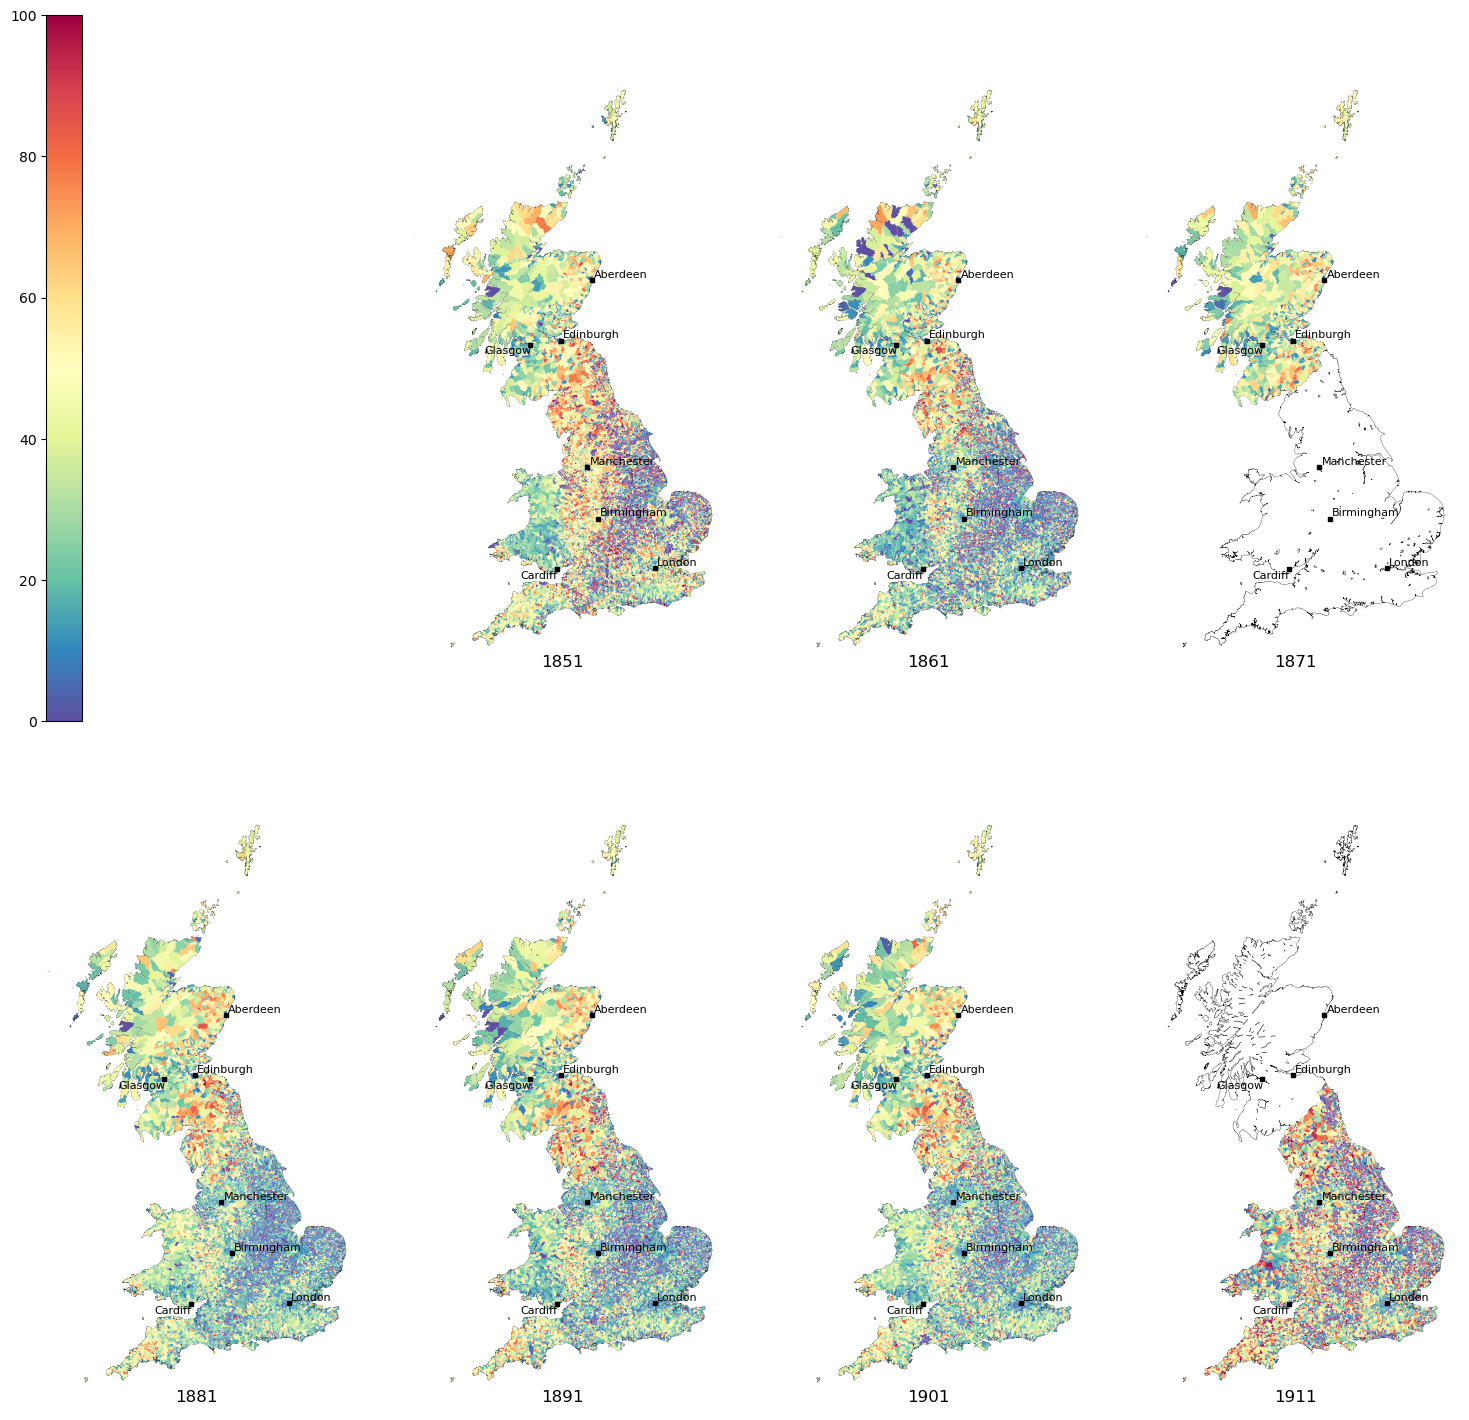

In [4]:
# col_to_plot = "os_open_roads_perc"
col_to_plot = "gb1900_perc"
# col_to_plot = "linked_total"
# gb1900_perc
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True,figsize=(15,15))
fig.tight_layout()
ncol = 0

value_min = 0
value_max = 100
cmap = "Spectral_r"


row_to_read = None
gb_outline = gpd.read_file(f"analysis/GB_outline_boundary.geojson")
cities = gpd.read_file("analysis/major_cities.geojson")
# 1861,1871,1881,1891,1901,1911,1921
for iter, year in enumerate([None, 1851,1861,1871,1881,1891,1901,1911]):
    # cax = axes[1,3]


    print(iter)
    # if iter < 2:
    #     iter_row = 0
    #     iter_col = iter
    # elif 2 >= iter <4:
    #     iter_row = 1
    #     iter_col = iter
    # elif 4 >= iter <6:
    #     iter_row = 2
    #     iter_col = iter
    # elif 6 >= iter <8:
    #     iter_row = 3
    #     iter_col = iter

    if iter < 4:
        iter_row = 0
        iter_col = iter
    else:
        iter_row = 1
        iter_col = iter - 4

    nrow = iter_row
    ncol = iter_col
    print(year)

    if nrow == 0 and ncol == 0:
        axes[nrow, ncol].axis("off")

    elif year < 1921:
    # ncol = iter

        if year == 1871:
            mapping_final = gpd.read_file(f"analysis_{output_suffix}/{year}/SCOT/{year}_SCOT_mapping_by_adm_unit_corrected.geojson", rows = row_to_read)
        elif year == 1911:
            mapping_final = gpd.read_file(f"analysis_{output_suffix}/{year}/EW/{year}_EW_mapping_by_adm_unit_corrected.geojson", rows = row_to_read)
        else:
            mapping_ew = gpd.read_file(f"analysis_{output_suffix}/{year}/EW/{year}_EW_mapping_by_adm_unit_corrected.geojson", rows = row_to_read)
            mapping_scot = gpd.read_file(f"analysis_{output_suffix}/{year}/SCOT/{year}_SCOT_mapping_by_adm_unit_corrected.geojson", rows = row_to_read)
            mapping_final = pd.concat([mapping_ew, mapping_scot])
        gb_outline.plot(ax=axes[nrow, ncol], color='white', edgecolor='black',linewidth=0.2, zorder = 0)
        mapping_final.plot(ax=axes[nrow, ncol],column=col_to_plot, vmin = value_min, vmax = value_max, cmap = cmap, zorder = 1)
        final = cities.plot(ax = axes[nrow, ncol], marker = "s", color = "black", zorder = 2, markersize=5)
        for label, x, y in zip(cities['place_name'], cities["geometry"].x, cities["geometry"].y):
            if label == "Glasgow":
                final.annotate(text = label, xy = (x,y), xytext = (x-100000,y-20000), fontsize = 8)
            elif label == "Cardiff":
                final.annotate(text = label, xy = (x,y), xytext = (x-80000,y-20000), fontsize = 8)
            else:
                final.annotate(text = label, xy = (x,y), xytext = (x+5000,y+5000), fontsize = 8)
        axes[nrow, ncol].axis("off")
        # axes[ncol].set(title=year)

        axes[nrow, ncol].set_title(label=year,y=0)


import matplotlib
mappable = matplotlib.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(value_min, value_max),
    cmap=cmap
)
axs = axes.ravel()
#  ax = axes[1,3],  location = "left"
cb = fig.colorbar(mappable,ax = axes[0,0], orientation='vertical', location = "left")
tick_font_size = 10
cb.ax.tick_params(labelsize=tick_font_size)
# axs = axes.ravel()
# print(axs)
# patch_col = axs[0].collections[0]
# print(patch_col)
# cb = fig.colorbar(patch_col, ax=axs)
high_dpi = 600
mid_dpi = 300
low_dpi = 100
plt.savefig(f"summary_map_{col_to_plot}_{high_dpi}_{output_suffix}.png", dpi = high_dpi)
plt.savefig(f"summary_map_{col_to_plot}_{mid_dpi}_{output_suffix}.png", dpi = mid_dpi)
plt.savefig(f"summary_map_{col_to_plot}_{low_dpi}_{output_suffix}.png", dpi = low_dpi)
